# Deep Image Analogy

Import the modules we need.

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from matplotlib import image
from PIL import Image
import cv2

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  2.2.0+cu118
Torchvision Version:  0.17.0+cu118
Using the GPU!


## Step 0: Downloading the dataset and backbone network.
A pretrained VGG 19 will be applied to extract features.

In [63]:
# Download the VGG19 model
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = {}
        out['conv11'] = self.conv1_1(x)
        out['r11'] = F.relu(out['conv11'])
        out['conv12'] = self.conv1_2(out['r11'])
        out['r12'] = F.relu(out['conv12'])
        out['p1'] = self.pool1(out['r12'])
        out['conv21'] = self.conv2_1(out['p1'])
        out['r21'] = F.relu(out['conv21'])
        out['conv22'] = self.conv2_2(out['r21'])
        out['r22'] = F.relu(out['conv22'])
        out['p2'] = self.pool2(out['r22'])
        out['conv31'] = self.conv3_1(out['p2'])
        out['r31'] = F.relu(out['conv31'])
        out['conv32'] = self.conv3_2(out['r31'])
        out['r32'] = F.relu(out['conv32'])
        out['conv33'] = self.conv3_3(out['r32'])
        out['r33'] = F.relu(out['conv33'])
        out['conv34'] = self.conv3_4(out['r33'])
        out['r34'] = F.relu(out['conv34'])
        out['p3'] = self.pool3(out['r34'])
        out['conv41'] = self.conv4_1(out['p3'])
        out['r41'] = F.relu(out['conv41'])
        out['conv42'] = self.conv4_2(out['r41'])
        out['r42'] = F.relu(out['conv42'])
        out['conv43'] = self.conv4_3(out['r42'])
        out['r43'] = F.relu(out['conv43'])
        out['conv44'] = self.conv4_4(out['r43'])
        out['r44'] = F.relu(out['conv44'])
        out['p4'] = self.pool4(out['r44'])
        out['conv51'] = self.conv5_1(out['p4'])
        out['r51'] = F.relu(out['conv51'])
        out['conv52'] = self.conv5_2(out['r51'])
        out['r52'] = F.relu(out['conv52'])
        out['conv53'] = self.conv5_3(out['r52'])
        out['r53'] = F.relu(out['conv53'])
        out['conv54'] = self.conv5_4(out['r53'])
        out['r54'] = F.relu(out['conv54'])
        out['p5'] = self.pool5(out['r54'])
        return out

cnn = VGG(pool='avg').eval().to('cuda')
cnn.load_state_dict(torch.load('./Models/vgg_conv.pth'))

# Freeze the parameters as there's no need to train the net. Ignore the warnings.
for param in cnn.parameters():
    param.requires_grad = False

## STEP 1: Create the image loader and some utility funtions
Provide the dataloader for images and a function to get the list of feature maps from a forward pass in the network.

In [64]:
# Dataloader
imsize = (256, 256)

VGG19_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
VGG19_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)


def image_loader(image_name, imsize):
    image = Image.open(image_name)
    transform = transforms.Compose([
        transforms.Resize(imsize),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=VGG19_MEAN.tolist(),
            std=VGG19_STD.tolist(),
        ),
        transforms.Lambda(lambda x: x.mul(255)),
        # It seems that the torchvision's VGG19 implementation is expecting the input to be in the 0-255 range, instead of 0-1
    ])
    image = transform(image)
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image.to(device, torch.float)

# visualizing the content and style images

A = image_loader("./Images/anni.jpg", imsize)
B_ = image_loader("./Images/mona.jpg", imsize)

print(A.shape)
print(B_.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


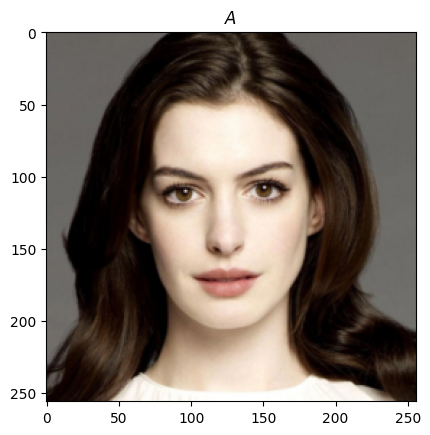

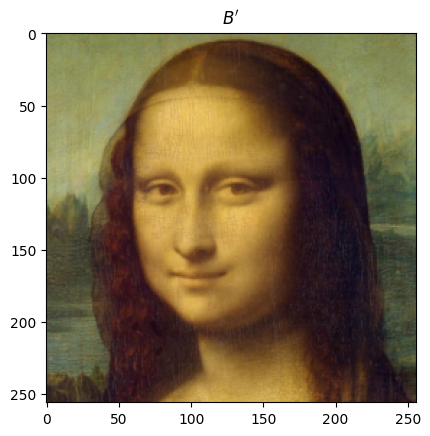

In [65]:
deprocess = transforms.Compose([
    transforms.Lambda(lambda x: x.mul(1/255)),
    transforms.Normalize(
        (0, 0, 0),
        (1.0 / VGG19_STD).tolist(),
    ),
    transforms.Normalize(
        (-VGG19_MEAN).tolist(),
        (1, 1, 1),
    ),
    transforms.Lambda(lambda x: x.clamp(0, 1)),
    transforms.ToPILImage(),
])

plt.ion()

def imshow(im_tensor, title=None):
    image = im_tensor.cpu().clone()    
    image = deprocess(image[0])
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(A, title='$A$')

plt.figure()
imshow(B_, title="$B'$")

## Step 2: Preprocess

First, we need to get the feature maps.

In [66]:
def get_feature_maps(x, cnn):
    """
    Get the list of feature maps in a forward pass.
    
    Inputs:
    - x: A batch of images with shape (B, C, H, W)
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of features for the input images x extracted using the cnn model.
      features[i] is a Tensor of shape (B, C_i, H_i, W_i).
    """
    feats = cnn(x)
    return feats

We only need five layers.

In [67]:
layers = ['r11', 'r21', 'r31', 'r41', 'r51']
feats_A = {k: v for k, v in get_feature_maps(A, cnn).items() if k in layers}
feats_B_ = {k: v for k, v in get_feature_maps(B_, cnn).items() if k in layers}

Initialize $F_{A'}^5$ and $F_B^5$ with $F_A^5$ $F_{B'}^5$ respectively (i.e. assume they are the same in the deepest layer).

In [68]:
feats_A_ = dict()
feats_B = dict()

feats_A_['r51'] = feats_A['r51']
feats_B['r51'] = feats_B_['r51']

## Step 3: Nearest-neighbor Field Search

Identify a mapping function

$$
\phi^L_{a\rightarrow b}(p)=\argmin\limits_q \sum\limits_{x\in N(p),y\in N(q)}
(||\bar{F}_A^L(x)-\bar{F}_B^L(y)||^2+||\bar{F}_{A'}^L(x)-\bar{F}_{B}'^L(y)||^2),
$$
where $N(p)$ is a patch around $p$, and $\bar{F}^L(x)=\frac{{F}^L(x)}{|{F}^L(x)|}$.

One idea is that $\phi^L_{a\rightarrow b}$ is constrained by $\phi^{L+1}_{b\rightarrow a}$ through $F_B^L$.

In [80]:
def normalize(feat):
    return feat / torch.norm(feat)


def get_patches(img, patch_size):
    """
    Get the patches of an image.
    
    Inputs:
    - img: A tensor of shape (B, C, H, W)
    - patch_size: The size of the patches
    - stride: The stride used to extract the patches
    
    Returns:
    - patches: A tensor of shape (B, C, H, W, patch_size, patch_size)
    """
    patches = img.unfold(2, patch_size, 1).unfold(3, patch_size, 1)
    return patches

def match_patches(A, B, A_, B_, patch_size=5):
    """
    Match the patches of A with the patches of B.

    Returns:
    - matches: A tensor of shape (N, H, W, 2) 
    where matches[0, i, j] = [a, b] means that 
    the patch at (i, j) in A matches with the patch at (a, b) in B.
    """
    # the loss is (squared error between A and B) + (A_ and B_)
    A_patches = get_patches(normalize(A), patch_size)
    B_patches = get_patches(normalize(B), patch_size)
    A_patches_ = get_patches(normalize(A_), patch_size)
    B_patches_ = get_patches(normalize(B_), patch_size)
    N, C, H, W, _, _ = A_patches.shape
    # get a dist matrix of shape (N, H, W, H, W)
    dist = torch.zeros(N, H, W, H, W)
    for i in range(H):
        for j in range(W):
            dist[:, i, j] = torch.sum((A_patches[:, :, i, j].unsqueeze(2).unsqueeze(2) - B_patches)**2, dim=(1, 4, 5))
            + torch.sum((A_patches_[:, :, i, j].unsqueeze(2).unsqueeze(2) - B_patches_)**2, dim=(1, 4, 5))
    indices = torch.argmin(dist.view(N, H, W, -1), dim=3)
    matches = torch.stack([indices // W, indices % W], dim=3)
    return matches


patch_sizes = {'r11': 5, 'r21': 5, 'r31': 3, 'r41': 3, 'r51': 3}
matches = match_patches(
    feats_A['r51'], feats_B['r51'], feats_A_['r51'], feats_B_['r51'], 
    patch_size=patch_sizes['r51']
)
print(matches.shape)

# visualize the matches
def visualize_matches(A, matches):
    """
    Visualize the matches between A and B.
    
    Inputs:
    - A: A tensor of shape (B, C, H, W)
    - matches: A tensor of shape (N, H, W, 2)
    """
    A = deprocess(A[0])
    A = np.array(A)
    A_after = np.copy(A)
    H, W, _ = A.shape
    for i in range(H):
        for j in range(W):
            a, b = matches[0, i, j]
            A_after[i, j] = A[a, b]
    plt.figure()
    plt.imshow(A_after)
    plt.title("A after matching")
    plt.show()

visualize_matches(A, matches)

torch.Size([1, 14, 14, 2])


IndexError: index 14 is out of bounds for dimension 2 with size 14